In [39]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from astropy.table import Table
import astropy.units as u
import scipy
from scipy import signal


from astropy.io import fits

# Using astropy BLS and scipy curve_fit to fit transit
from astropy.timeseries import BoxLeastSquares
from scipy.optimize import curve_fit

import scipy.optimize as opt

# Using emcee & corner to find and plot (e, w) distribution
import emcee
import corner

import dynesty

# And importing `photoeccentric`
import photoeccentric as ph

# Random stuff
import scipy.constants as c
import os

import random

%load_ext autoreload
%autoreload 2

%matplotlib inline

plt.rcParams['figure.figsize'] = [12, 8]

smass_kg = 1.9885e30  # Solar mass (kg)
srad_m = 696.34e6 # Solar radius (m)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Reading in Sample Data

In [3]:
spectplanets = pd.read_csv('spectplanets.csv')
muirhead_comb = pd.read_csv('muirhead_comb.csv')
muirhead_comb_lums = pd.read_csv('muirhead_comb_lums.csv')
muirhead_lamost = pd.read_csv('muirhead_lamost.csv')

In [4]:
KICs = np.sort(np.unique(np.array(muirhead_comb['KIC'])))
KOIs = np.sort(np.unique(np.array(muirhead_comb['KOI'])))

In [5]:
strkois = [str(i) for i in KOIs]

In [6]:
strkois = ['KOI ' + i for i in strkois]

In [7]:
lcpath = '/Users/ssagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/notebooks/datafiles/sample_LCs/'
lclist = []

for i in range(len(KICs)):
    templst = []
    for subdir, dirs, files in os.walk(lcpath):
        for file in files:
            if str(KICs[i]) in file:
                templst.append(os.path.join(subdir, file))
    lclist.append(templst)

In [8]:
KIC1 = 9710326

In [9]:
def get_stitched_lcs(KOI, KIC):
    
    files = lclist[int(np.argwhere(KICs==KIC))]
    #print(np.argwhere(KICs==KIC))
    #print(files)

    files = sorted(files)
    
    time = []
    flux = []
    flux_err = []
    hdus = []
    
    starttimes = []
    stoptimes = []
    
    for file in files:
        #print(file)
        hdu = fits.open(file)
        
        time_p = list(hdu[1].data['TIME'] + hdu[1].header['BJDREFI'] + hdu[1].header['BJDREFF'])
        time.append(time_p)
        
        flux_p = hdu[1].data['PDCSAP_FLUX']
        flux_err_p = hdu[1].data['PDCSAP_FLUX_ERR']
        
        fmed = np.nanmedian(flux_p)

        start = hdu[1].header['TSTART'] + hdu[1].header['BJDREFI'] + hdu[1].header['BJDREFF']
        starttimes.append(start)
        
        stop = hdu[1].header['TSTOP'] + hdu[1].header['BJDREFI'] + hdu[1].header['BJDREFF']
        stoptimes.append(stop)
        
        #print(hdu[1].data['TIMECORR'])
        
        flux.append(list(flux_p/fmed))
        flux_err.append(list(flux_err_p/fmed))
        
        hdus.append(hdu)


        #hdu.close()
    
    return hdus, time, flux, flux_err, starttimes, stoptimes

In [10]:
hdus, t, f, fe, starts, stops = get_stitched_lcs('947', 9710326)
#hdus[0][1].header

In [11]:
alltime_noclip = []
allflux_noclip = []
allfluxerr_noclip = []

for sublist in t:
    for item in sublist:
        alltime_noclip.append(item)
        
for sublist in f:
    for item in sublist:
        allflux_noclip.append(item)
        
for sublist in fe:
    for item in sublist:
        allfluxerr_noclip.append(item)

In [12]:
def sigma_clip(time, flux, fluxerr, sig=4):
    for i in tqdm(range(len(flux))):
        if flux[i] > np.nanmean(flux) + sig*np.nanstd(flux) or flux[i] < np.nanmean(flux) - sig*np.nanstd(flux):
            time[i] = np.nan
            flux[i] = np.nan
            fluxerr[i] = np.nan
            
    return time, flux, fluxerr
            

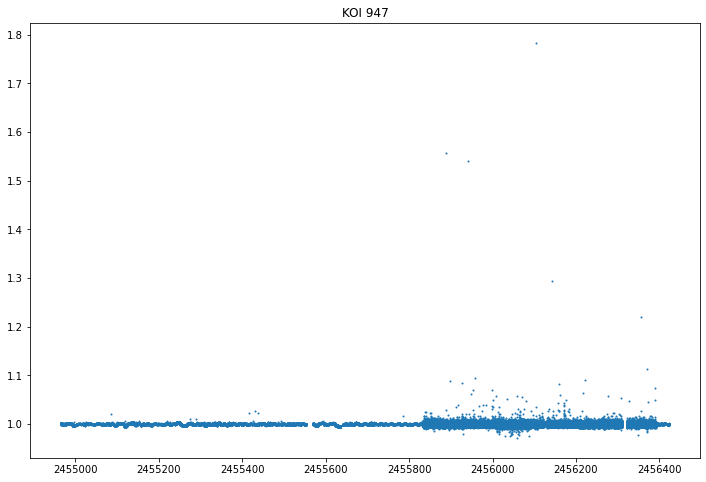

In [13]:
# alltime, allflux, allfluxerr = sigma_clip(alltime_noclip, allflux_noclip, allfluxerr_noclip, sig=4)

time, flux, flux_err = np.array(alltime_noclip), np.array(allflux_noclip), np.array(allfluxerr_noclip)

plt.scatter(time, flux, s=1)
plt.title('KOI 947')

plt.ticklabel_format(useOffset=False, style='plain')

In [58]:
total_obstime = time[-1]-time[0]

In [59]:
total_obstime

1459.489153879229

# KOI 947

In [47]:
kepid = 9710326
kepname = spectplanets.loc[spectplanets['kepid'] == kepid].kepler_name.values[0]

In [48]:
isodf = pd.read_csv("datafiles/isochrones/iso_lums_" + str(kepid) + ".csv")

mstar = isodf["mstar"].mean()
mstar_err = isodf["mstar"].std()

rstar = isodf["radius"].mean()
rstar_err = isodf["radius"].std()

In [49]:
period, period_uerr, period_lerr, rprs, rprs_uerr, rprs_lerr, a_arc, a_uerr_arc, a_lerr_arc, i, e_arc, w_arc = ph.planet_params_from_archive(spectplanets, kepname)

# We calculate a_rs to ensure that it's consistent with the spec/Gaia stellar density.
a_rs = ph.calc_a(period*86400.0, mstar*smass_kg, rstar*srad_m)
a_rs_err = np.mean((a_uerr_arc, a_lerr_arc))

print('Stellar mass (Msun): ', mstar, 'Stellar radius (Rsun): ', rstar)
print('Period (Days): ', period, 'Rp/Rs: ', rprs)
print('a/Rs: ', a_rs)
print('i (deg): ', i)

Stellar mass (Msun):  0.48797798116154106 Stellar radius (Rsun):  0.4690682721275218
Period (Days):  28.59914031 Rp/Rs:  0.036375
a/Rs:  65.99499728728715
i (deg):  89.99


In [50]:
transitmpt = 2455022.92667000

In [51]:
midpoints = np.concatenate((np.arange(transitmpt, starts[0], -period), np.arange(transitmpt, stops[-1], period)))

In [52]:
def get_KIC(KOI, muirhead_comb):
    return muirhead_comb[muirhead_comb['KOI'] == str(KOI)].KIC.item()

Transit duration for KOI 947: 3.6567 hrs

In [99]:
# hour to day conversion
htod = 0.0416667
dtoh = 24

In [115]:
# transit duration in hours
tdur = 3.6567

# CDPP time
t_CDPP = 3

# CDPP N
CDPP_3h = hdus[0][1].header['CDPP3_0']

# Total time object was observed
# approximately
tobs = total_obstime*dtoh

In [116]:
#hdus[0][1].header

In [122]:
def get_CDPPeff(CDPP_N, t_CDPP, t_dur):
    CDPPeff = np.sqrt(t_CDPP/t_dur)*CDPP_N
    print(np.sqrt(t_CDPP/t_dur))
    return CDPPeff

In [125]:
CDPP_eff

204.25880469681553

In [126]:
def get_SNR(CDPPeff, tobs, f0, P, depth):
    """Valid for a single transit."""
    
    SNR = np.sqrt((tobs*f0)/P)*(depth/CDPPeff)
    return SNR

In [127]:
period = 28.599140310*dtoh
depth = 0.036375**2

In [128]:
nbuffer = 11

7.14371215060765


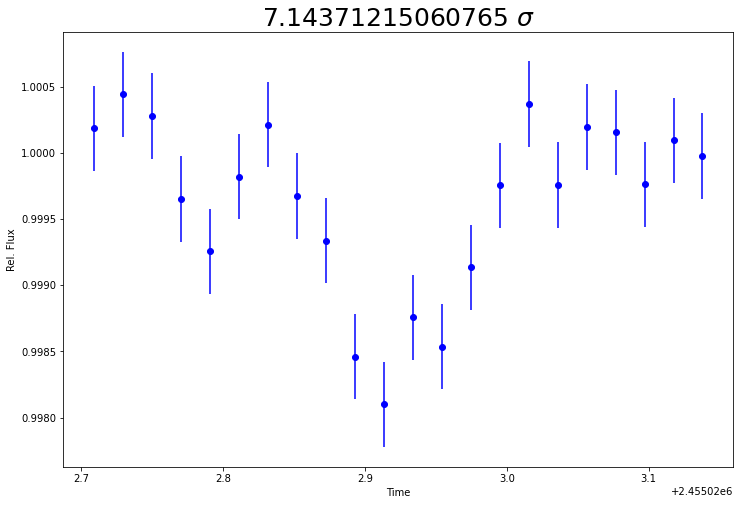

7.14371215060765


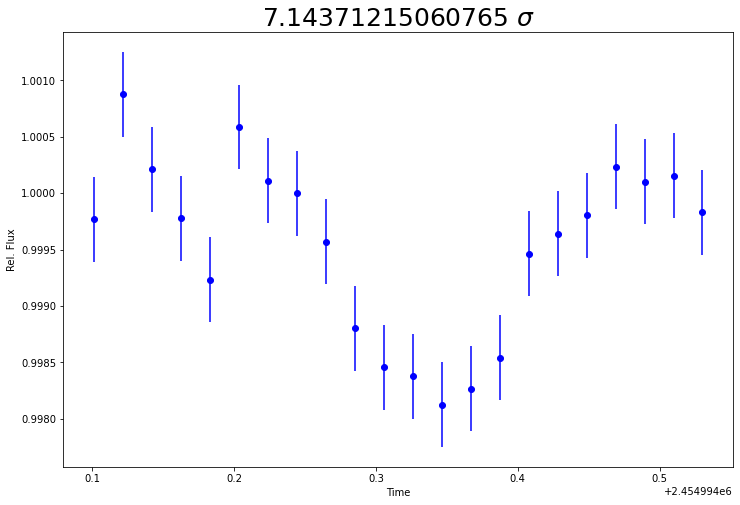

7.14371215060765


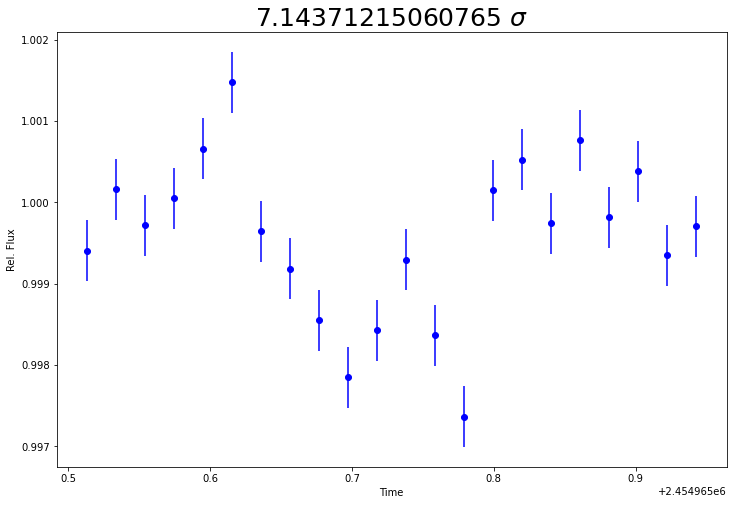

7.14371215060765


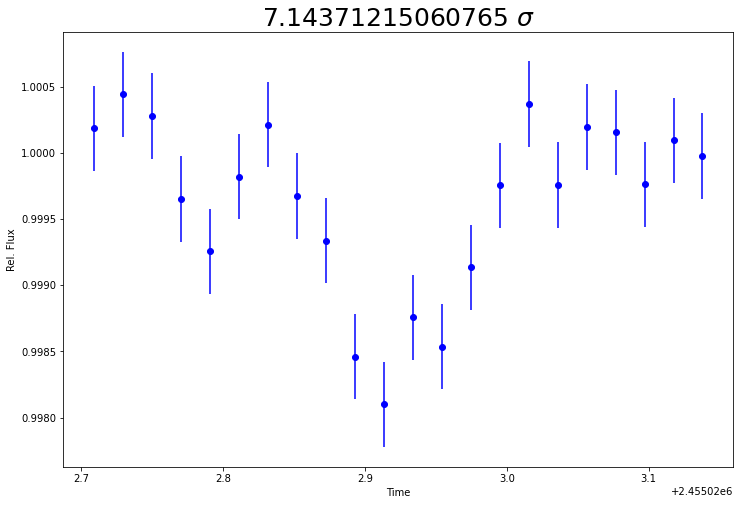

7.14371215060765


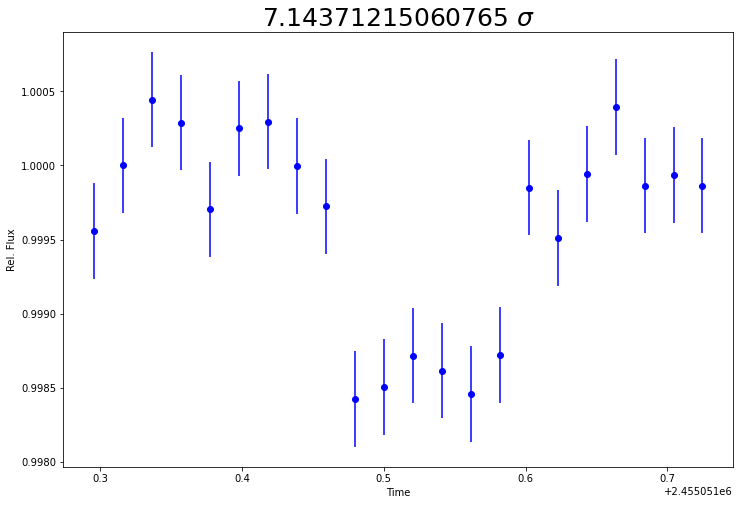

7.14371215060765


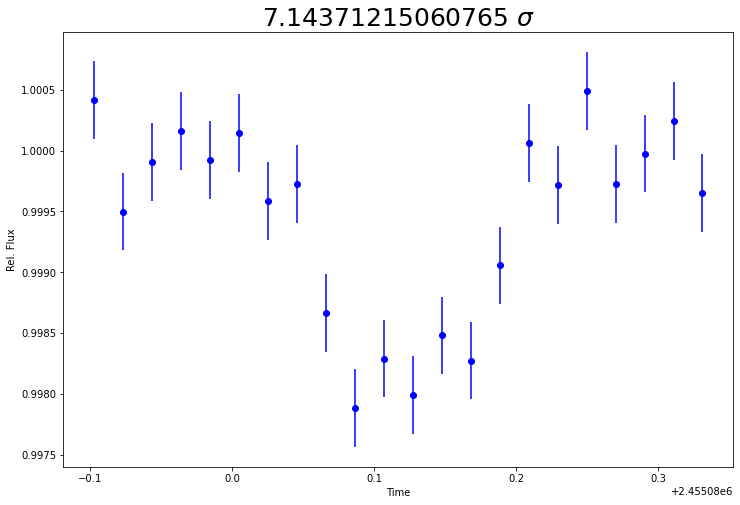

7.14371215060765


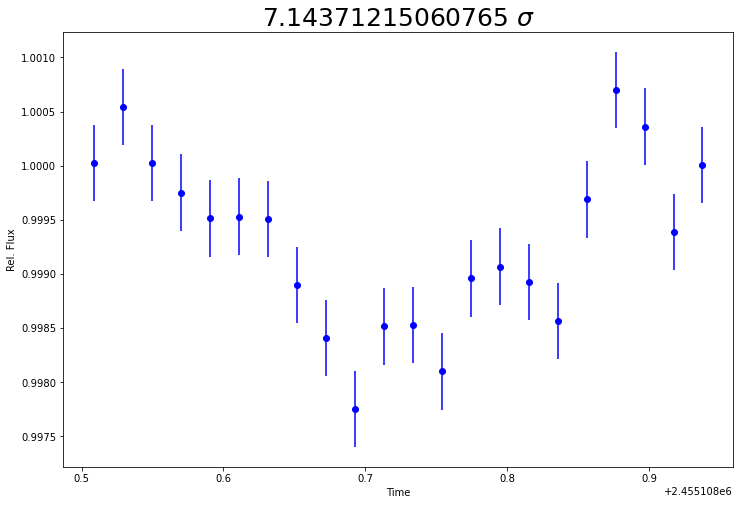

7.14371215060765


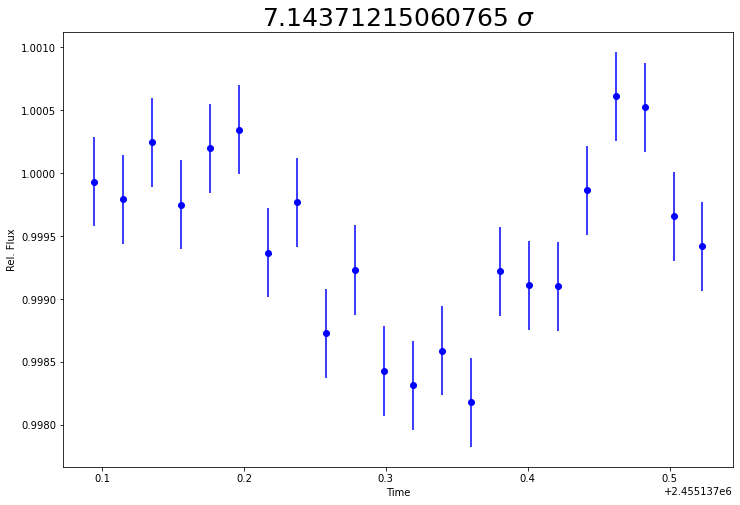

7.14371215060765


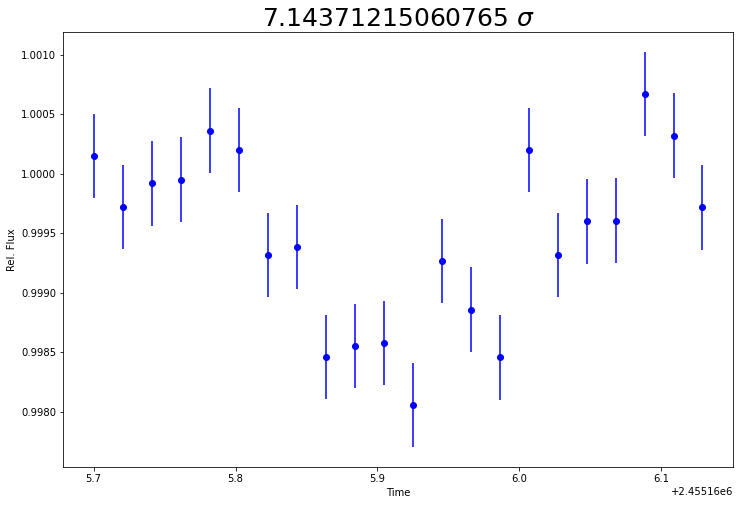

7.14371215060765


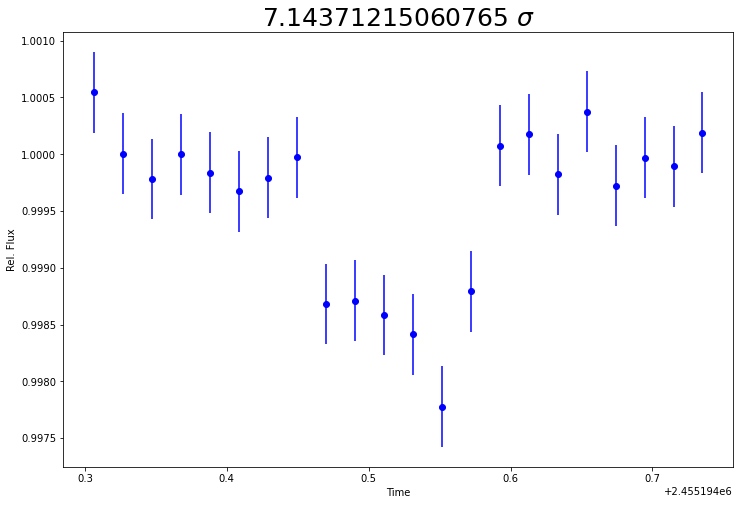

7.14371215060765


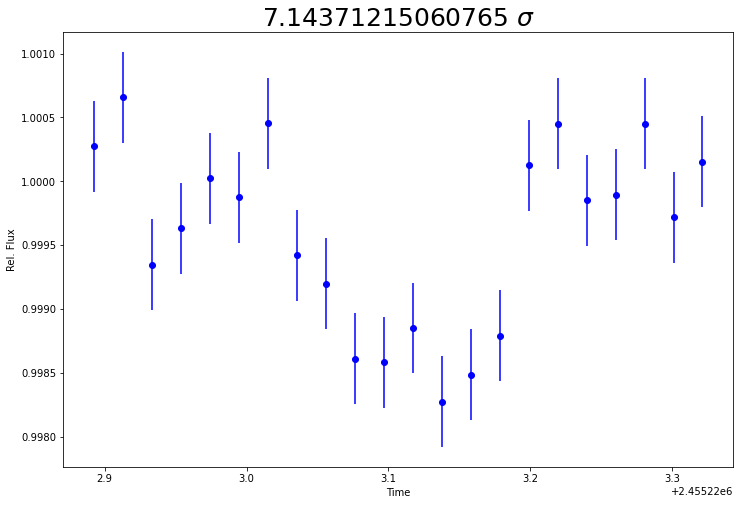

7.14371215060765


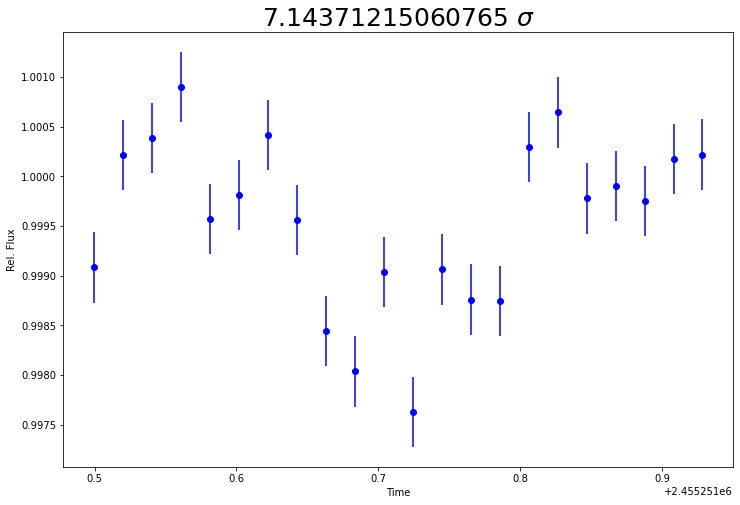

7.14371215060765


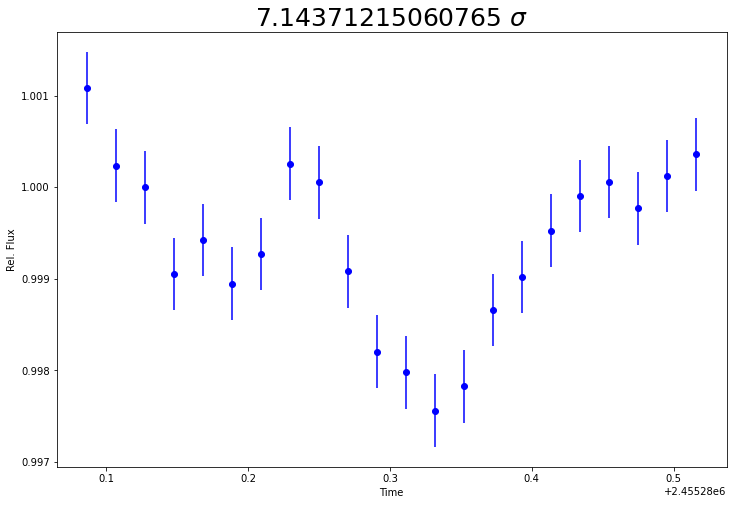

7.14371215060765


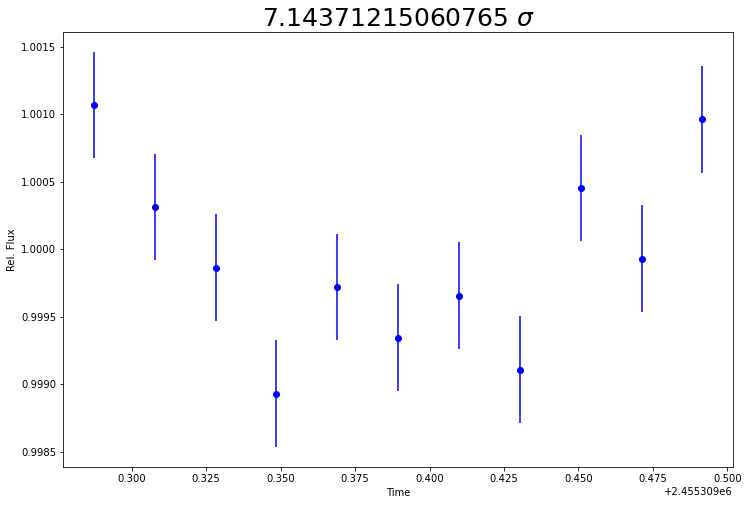

7.14371215060765


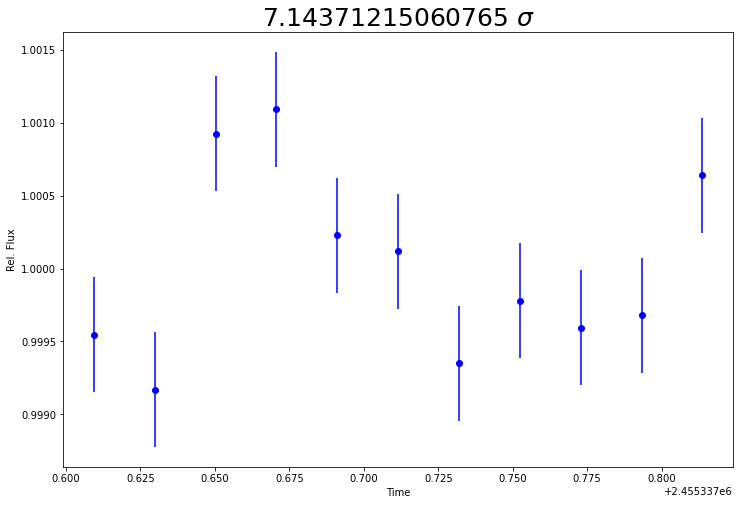

7.14371215060765


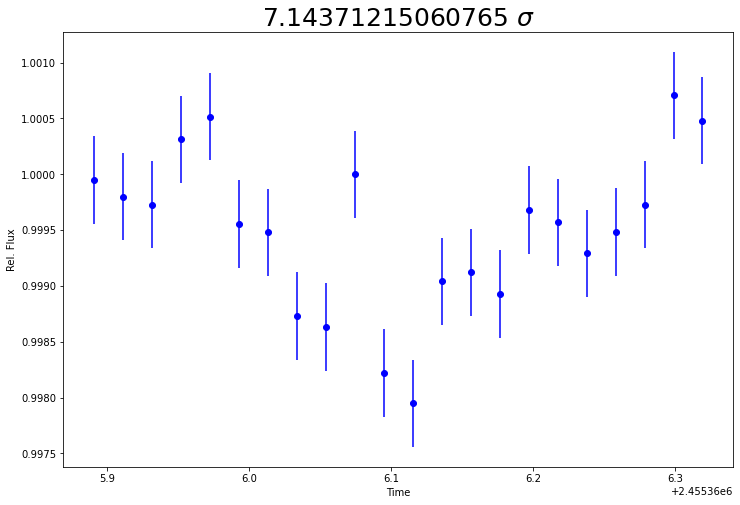

7.14371215060765


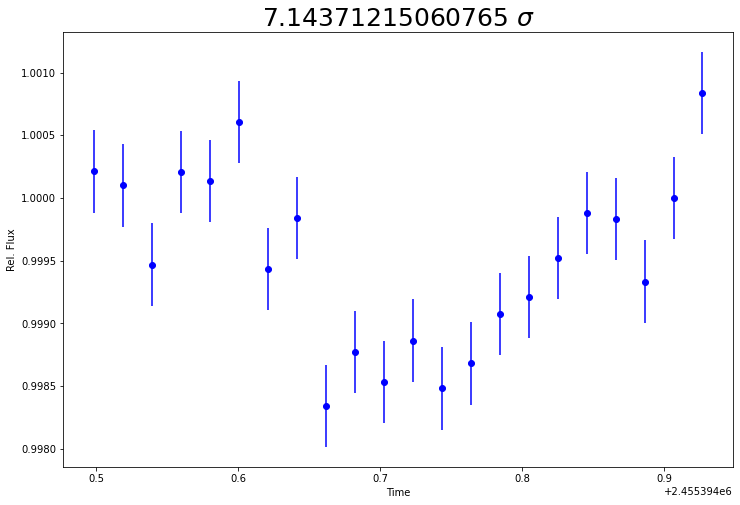

7.14371215060765


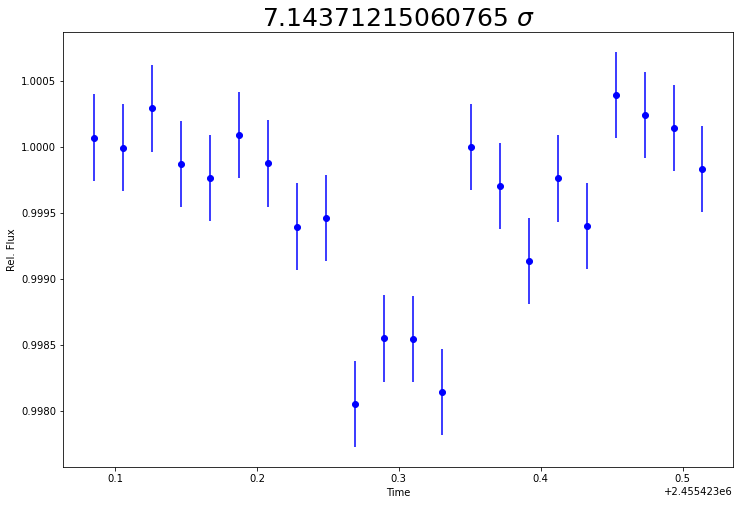

7.14371215060765


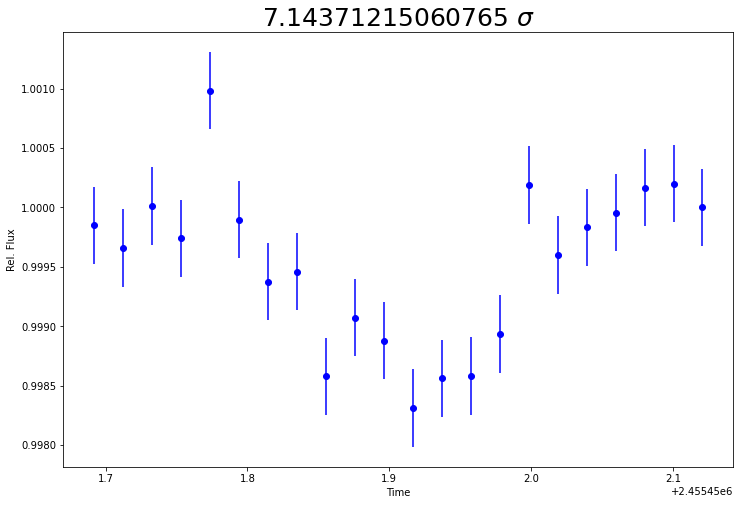

7.14371215060765


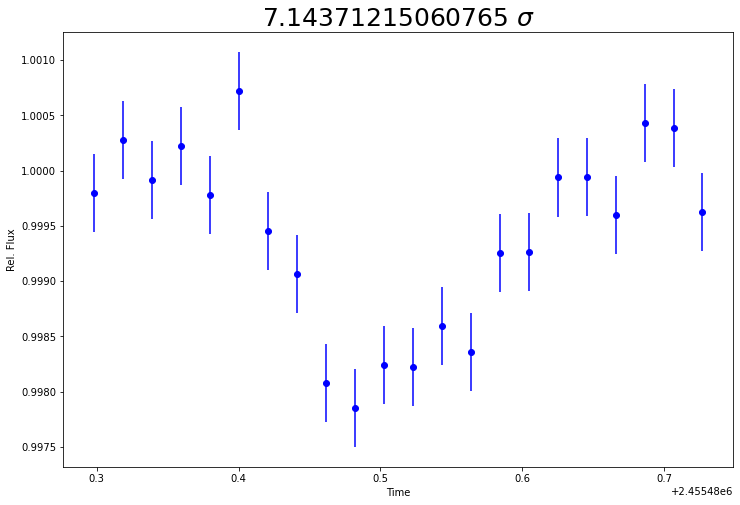

7.14371215060765


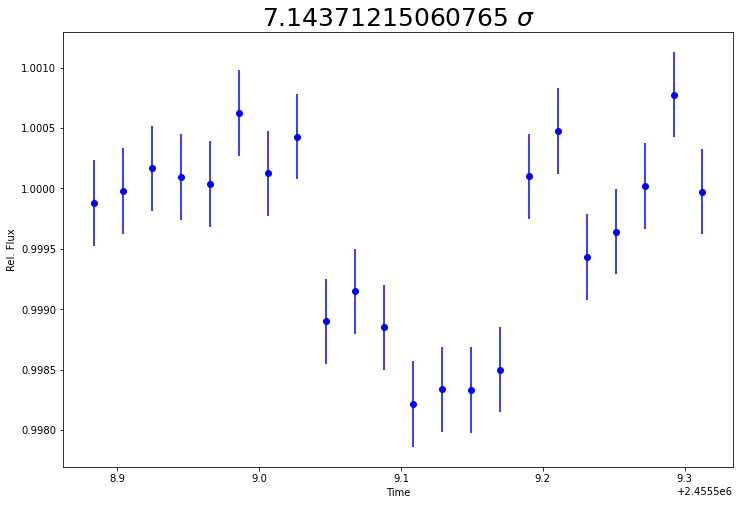

7.14371215060765


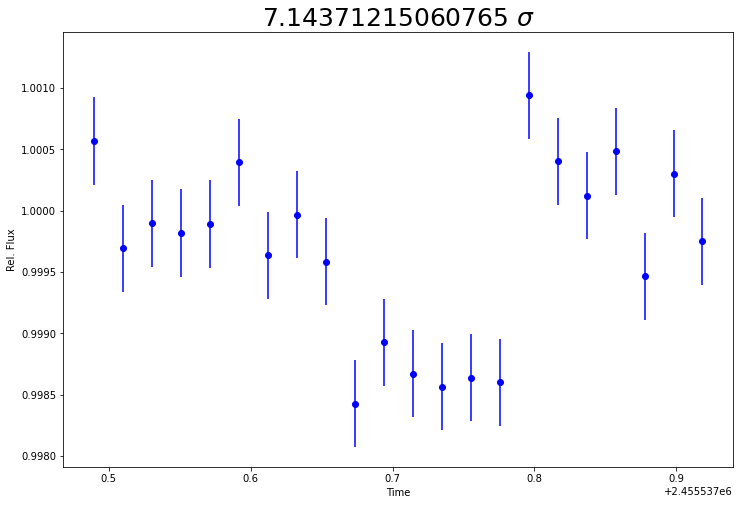

7.14371215060765


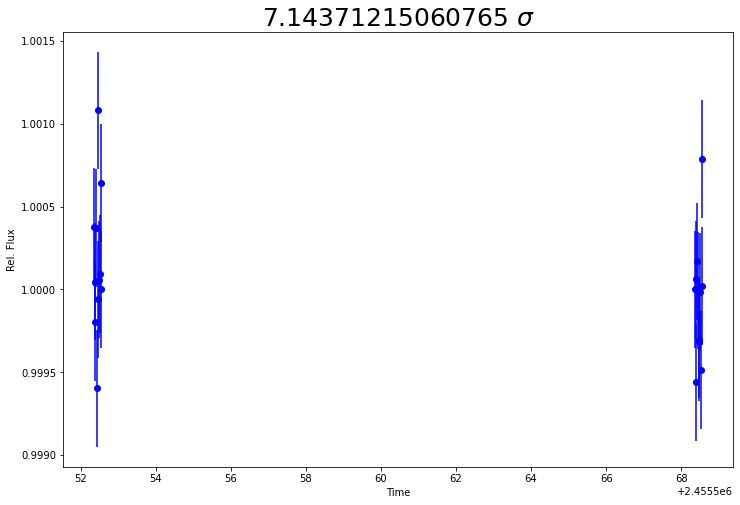

7.14371215060765


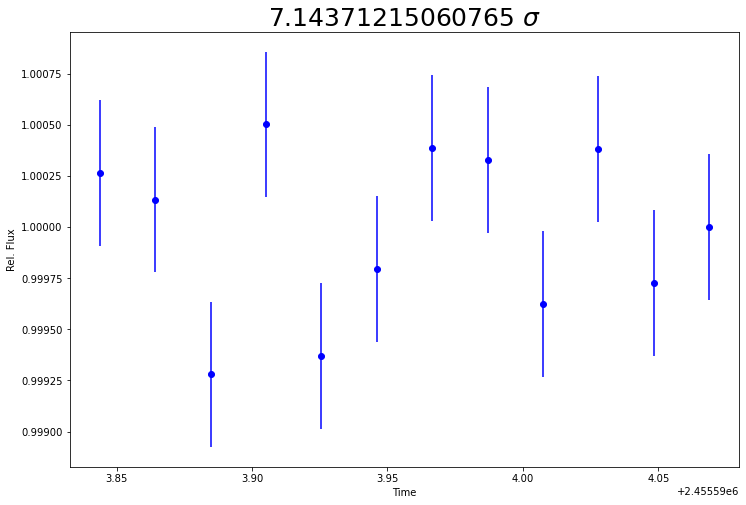

7.14371215060765


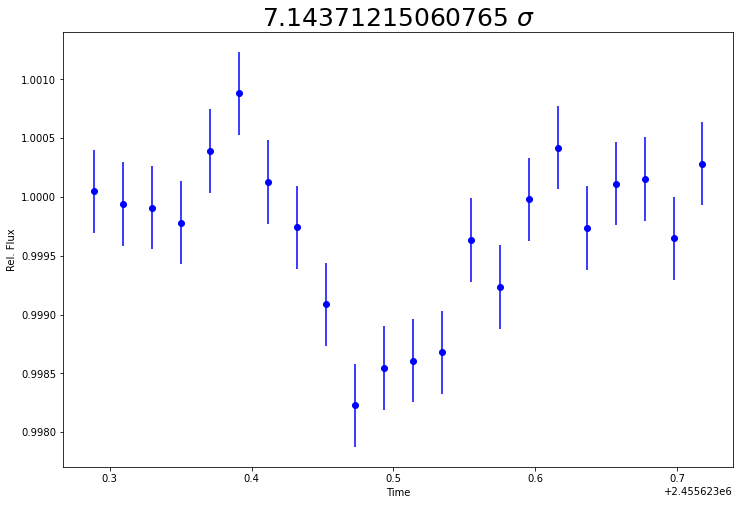

7.14371215060765


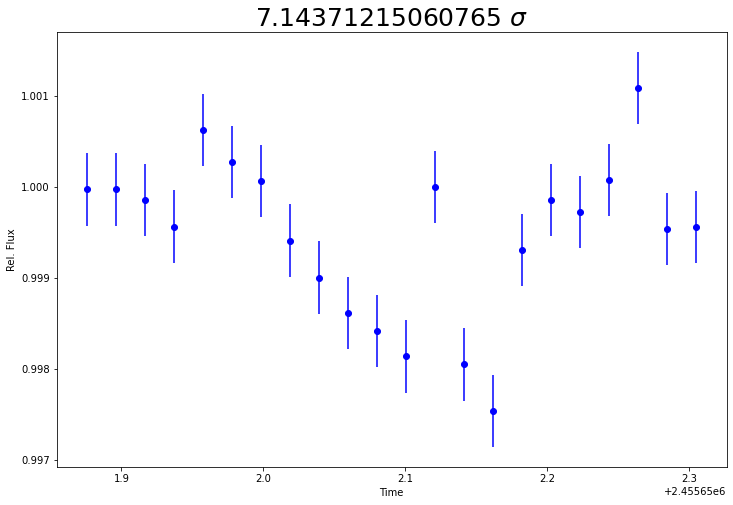

7.14371215060765


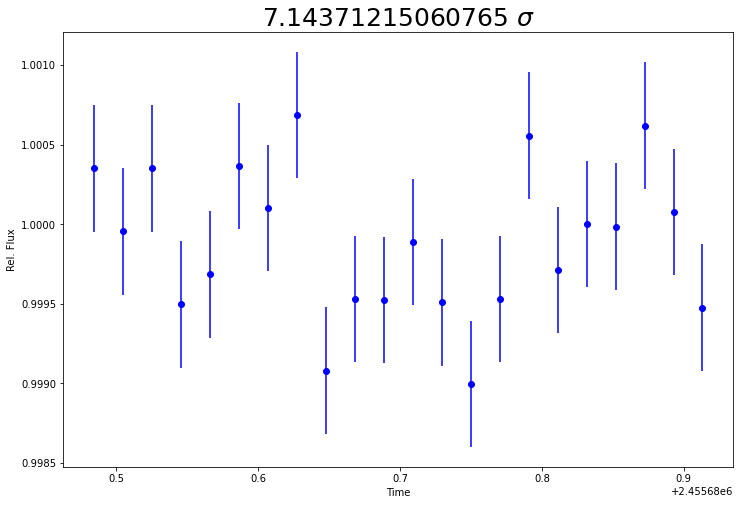

7.14371215060765


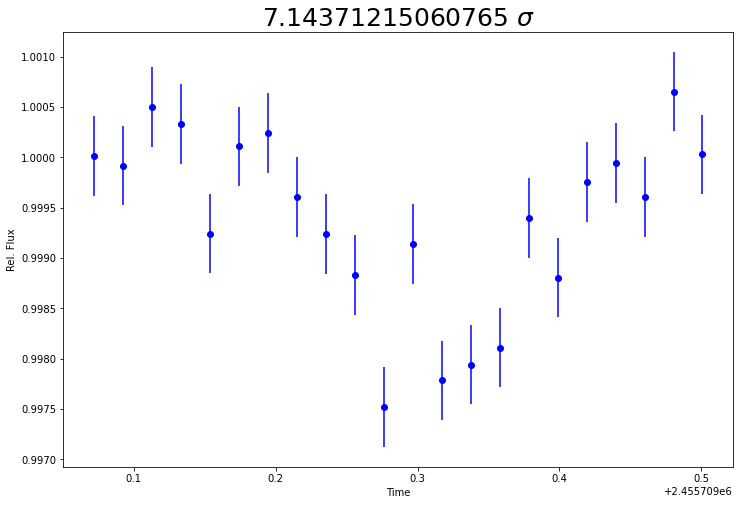

7.14371215060765


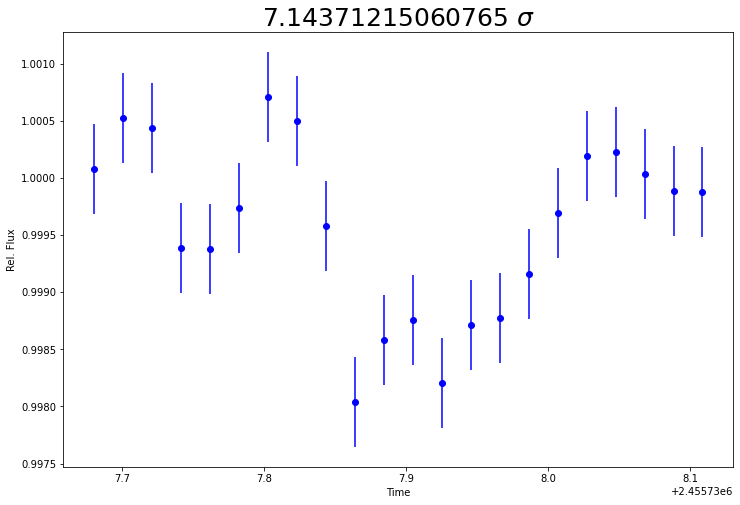

7.14371215060765


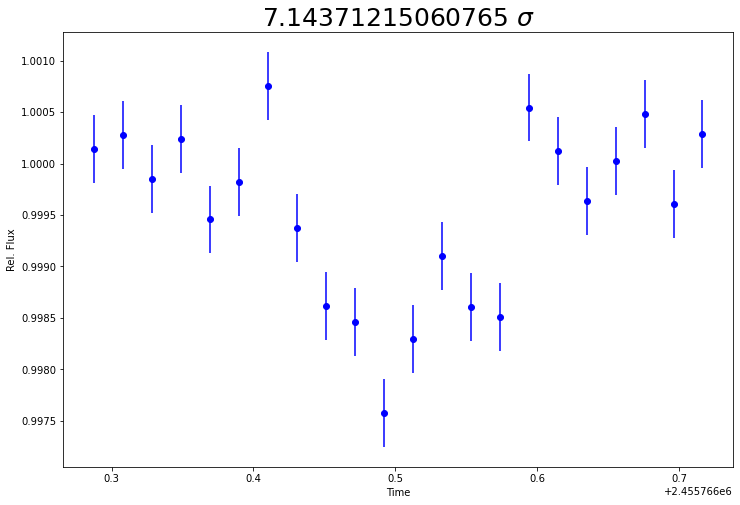

7.14371215060765


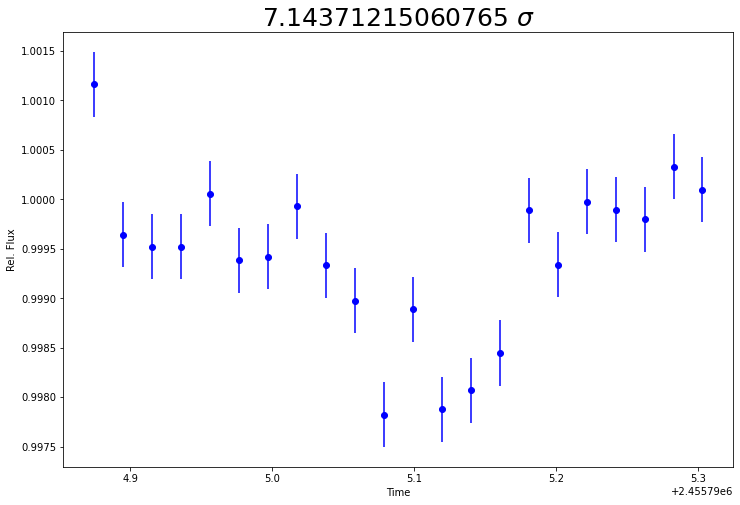

7.14371215060765


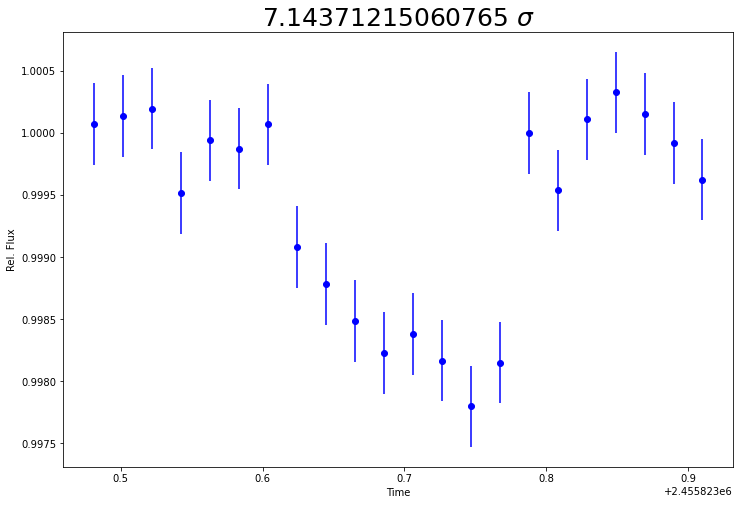

7.14371215060765


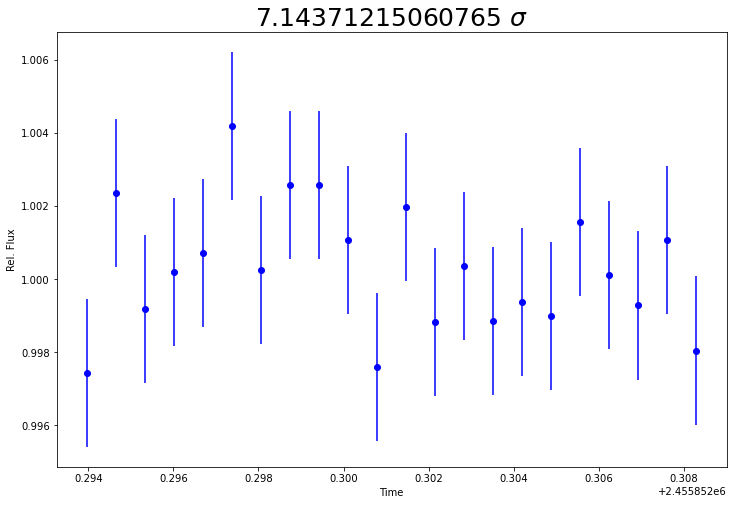

7.14371215060765


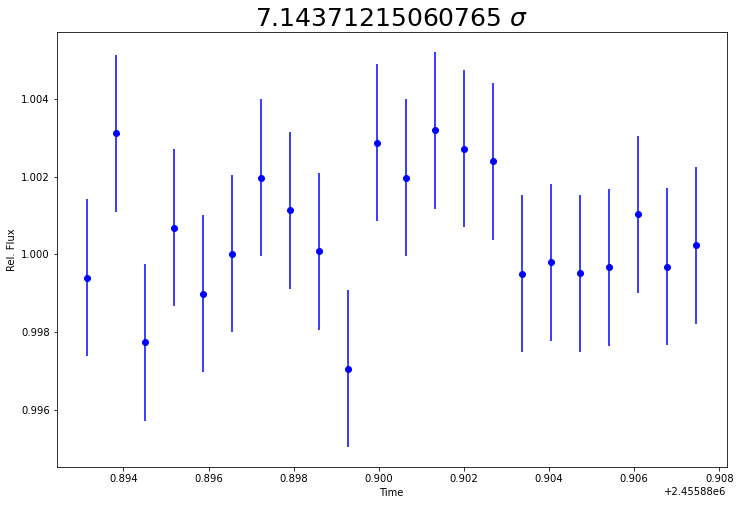

7.14371215060765


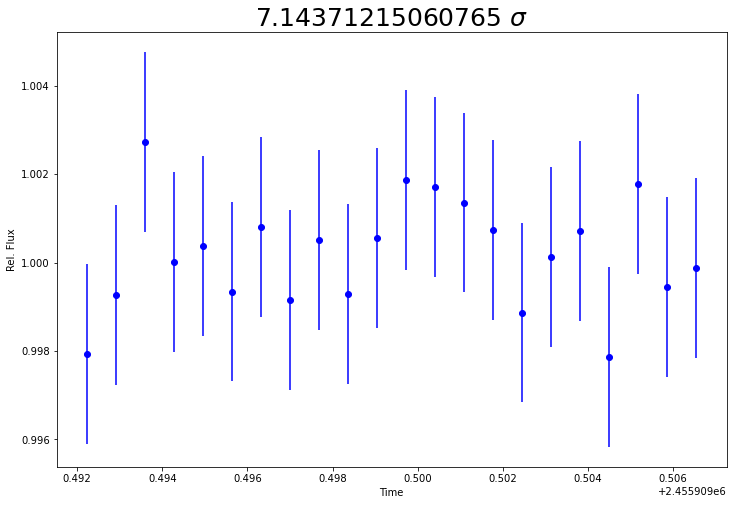

7.14371215060765


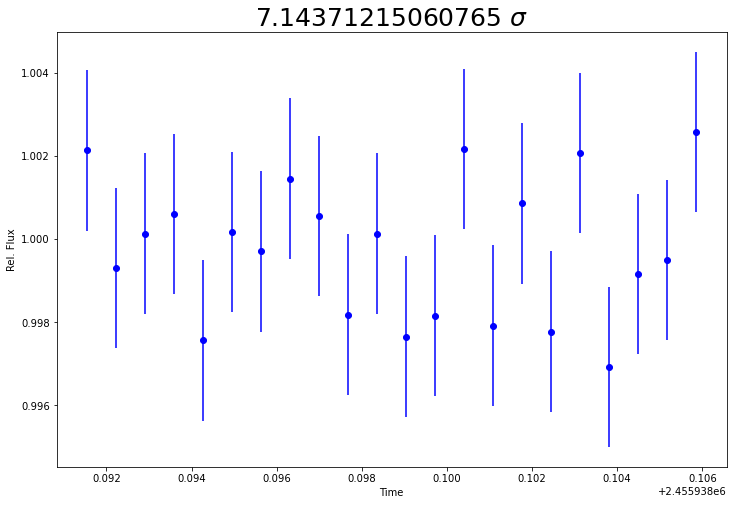

7.14371215060765


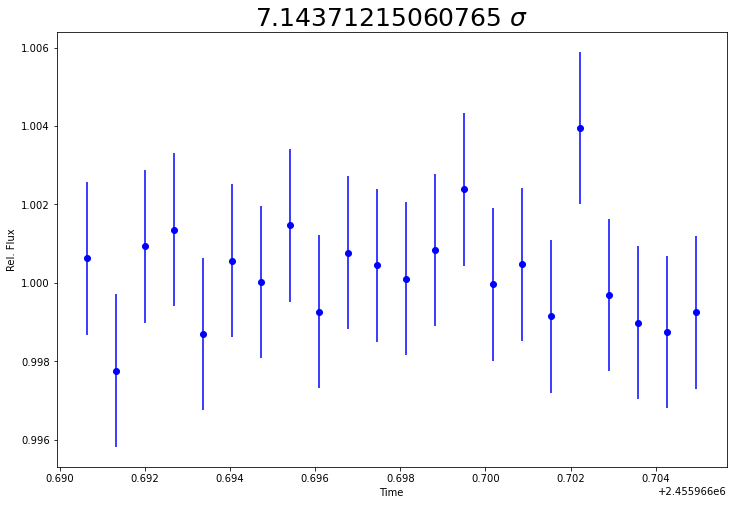

7.14371215060765


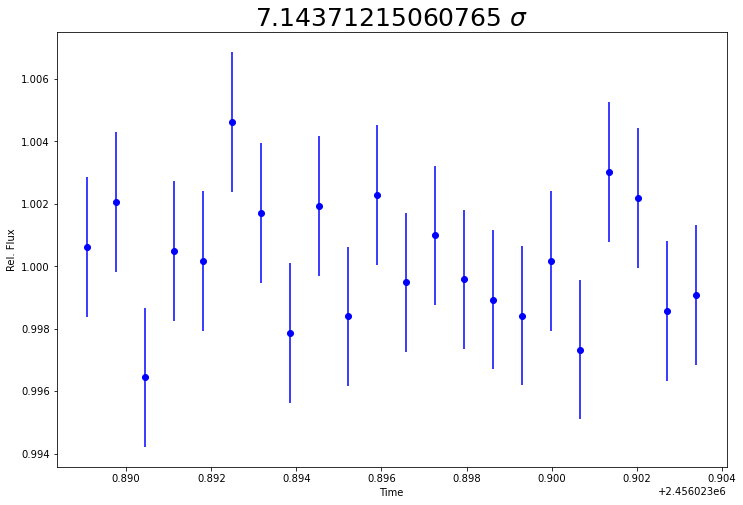

7.14371215060765


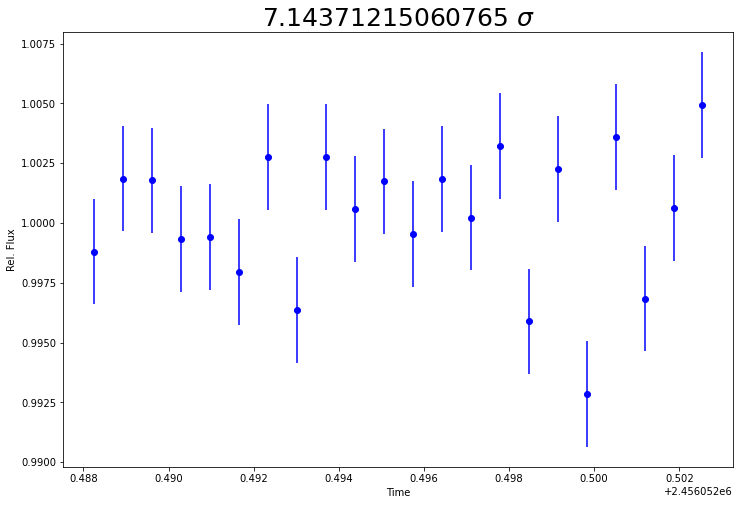

7.14371215060765


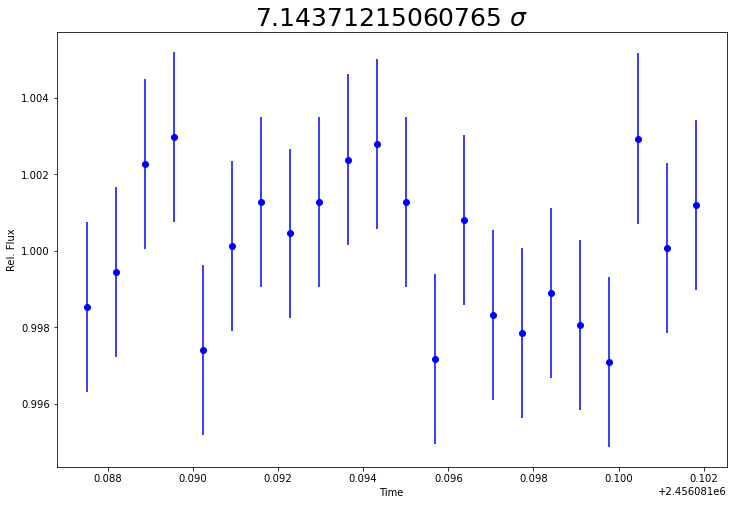

7.14371215060765


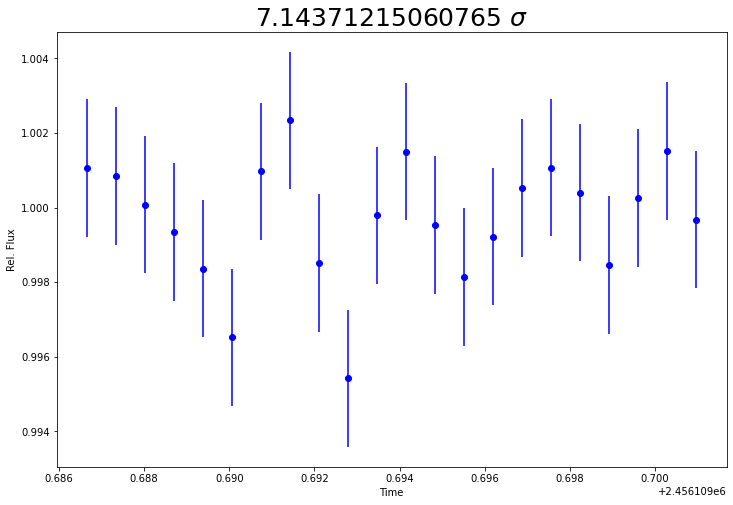

7.14371215060765


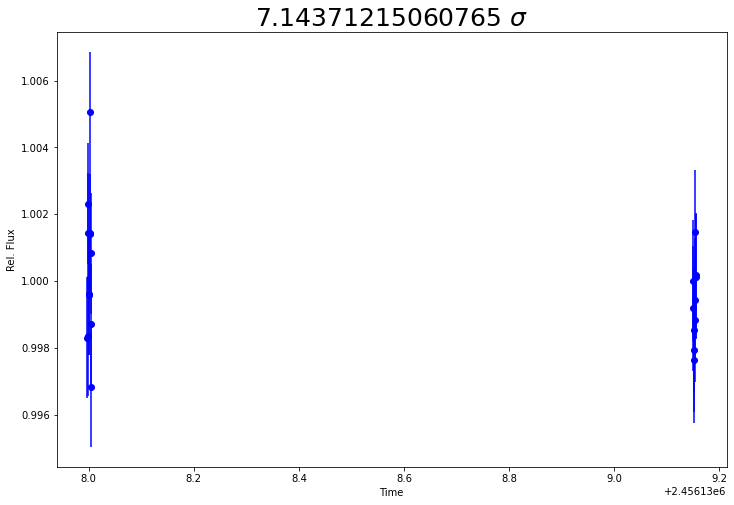

7.14371215060765


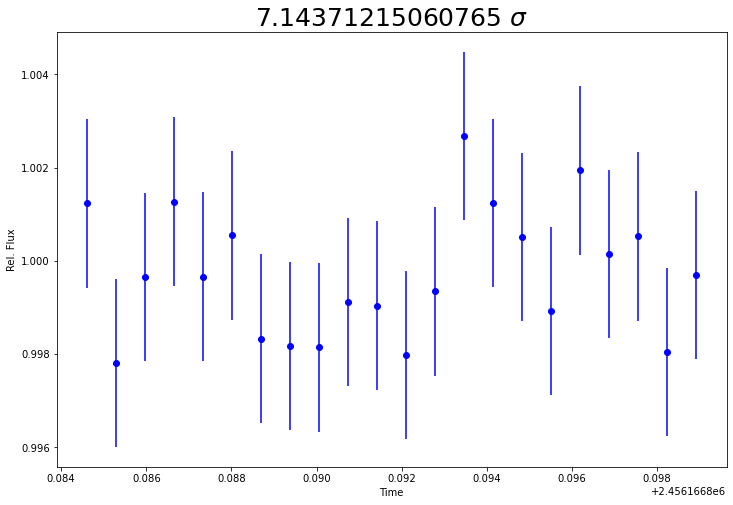

7.14371215060765


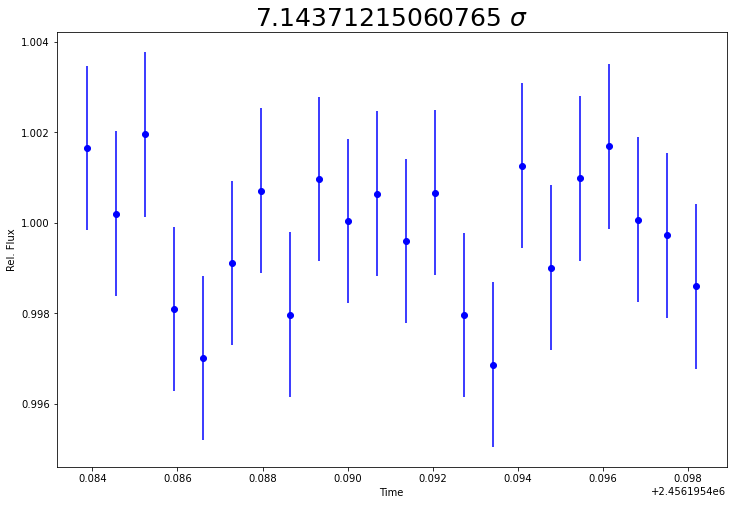

7.14371215060765


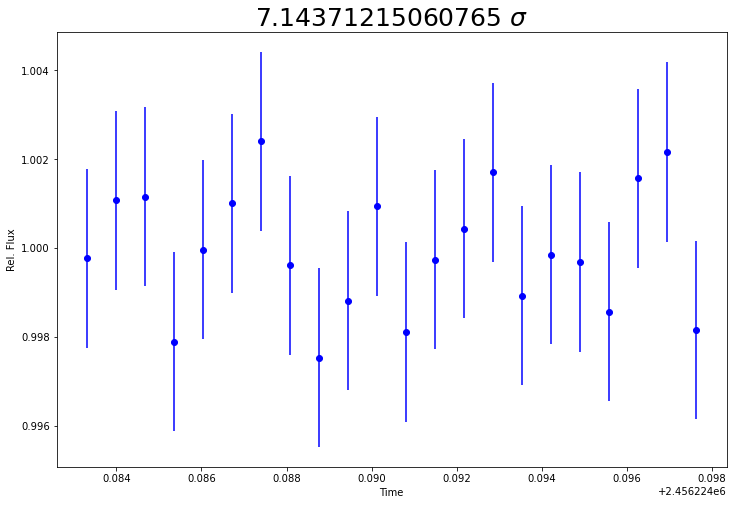

7.14371215060765


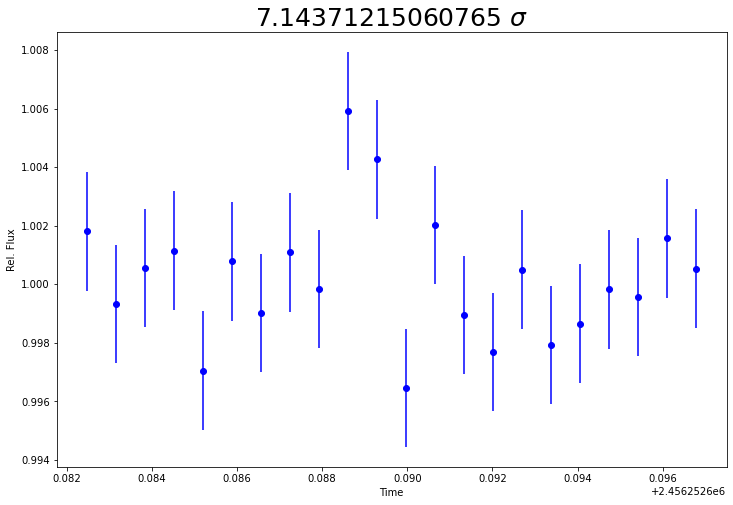

7.14371215060765


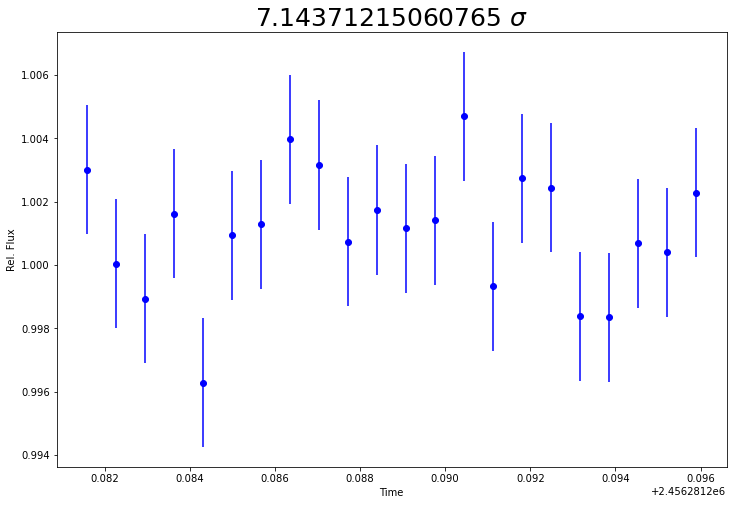

7.14371215060765


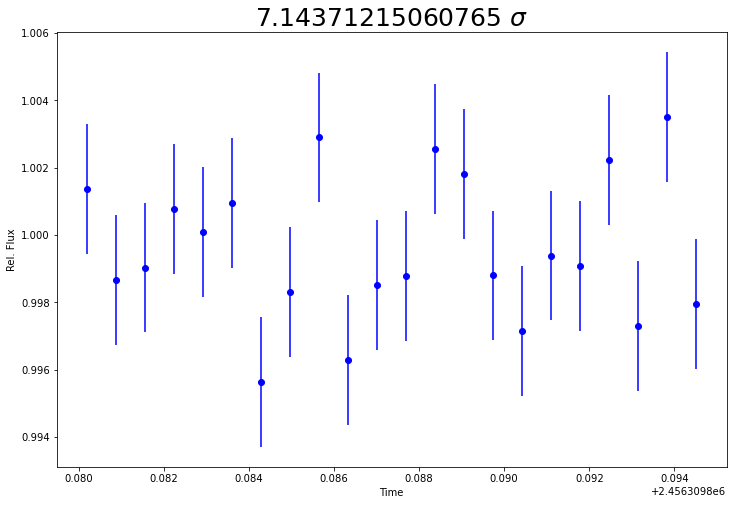

7.14371215060765


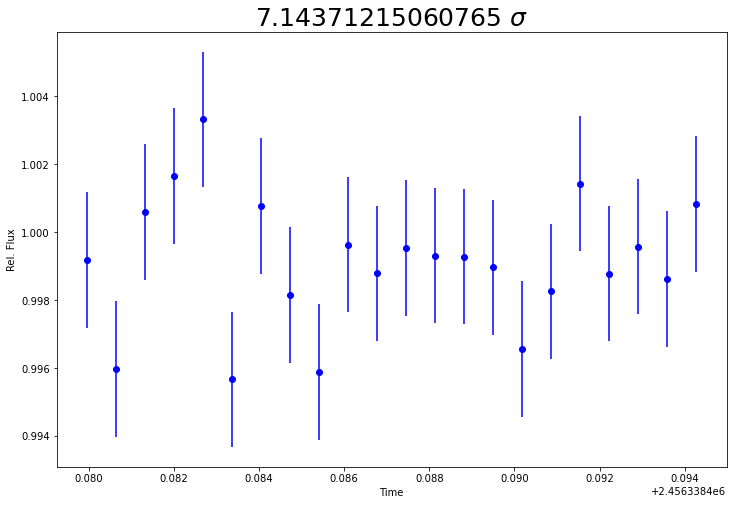

7.14371215060765


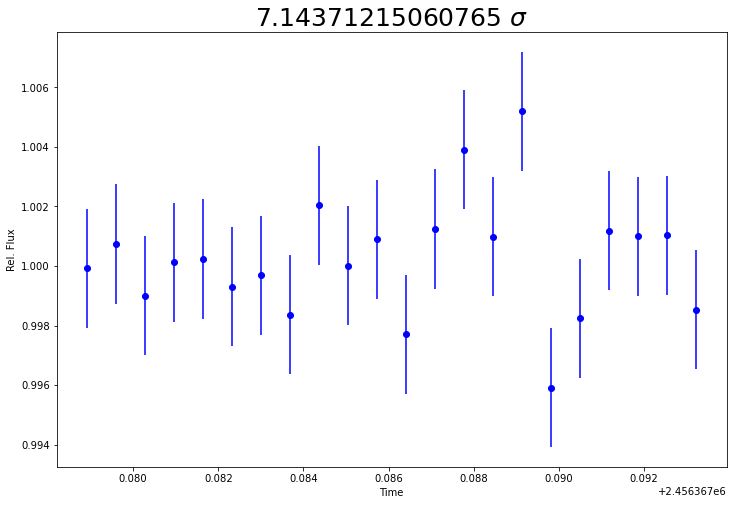

7.14371215060765


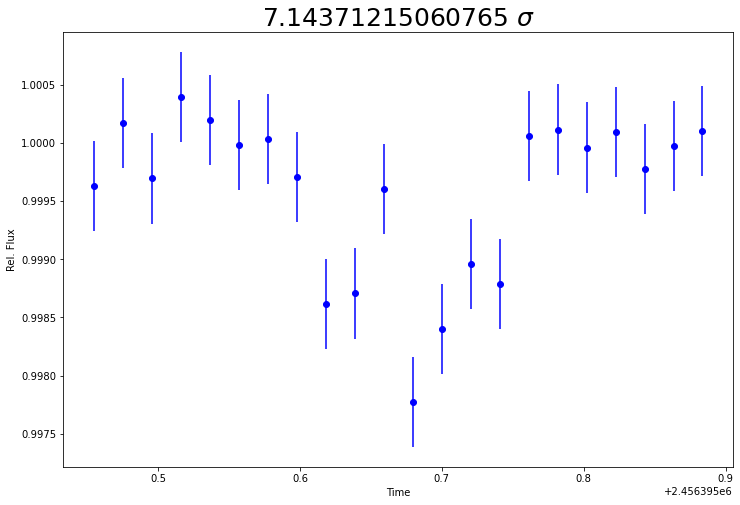

In [139]:
for ind in range(0, len(midpoints)):

    try:

        transitmid = midpoints[ind]

        tindex = int(np.where(time == ph.find_nearest(time, transitmid))[0])

        t1 = np.array(time[tindex-nbuffer:tindex+nbuffer]) - transitmid
        t1bjd = np.array(time[tindex-nbuffer:tindex+nbuffer])

        f1 = np.array(flux[tindex-nbuffer:tindex+nbuffer])
        fe1 = np.array(flux_err[tindex-nbuffer:tindex+nbuffer])

        tindex = int(np.where(time == ph.find_nearest(time, transitmid))[0])

        idx = np.isfinite(t1) & np.isfinite(f1)

        disc = 5
        m, b = np.polyfit(np.concatenate((t1[idx][:disc], t1[idx][-disc:])), np.concatenate((f1[idx][:disc], f1[idx][-disc:])), 1)

        linfit = m*t1 + b
        fnorm = (f1-linfit)+1

        mid = ph.get_mid(time)
        ptime = ph.get_ptime(t1, mid, 29)

        fnorm = np.nan_to_num(fnorm, nan=1.0)
        fe1 = np.nan_to_num(fe1, nan=np.nanmedian(fe1))
                 
        #frac0 = (t1bjd[-1]-t1bjd[0])/tobs
        frac0 = 1
                 
        SNR = get_SNR(CDPP_eff, tobs, frac0, period, depth)
        sigma = depth/CDPP_eff
        print(SNR/sigma)
        
        
        plt.cla()
        plt.errorbar(t1bjd, fnorm, yerr=fe1, fmt='o', c='blue')
        plt.xlabel('Time')
        plt.ylabel('Rel. Flux')
        plt.title(str(SNR/sigma) + " $\sigma$", fontsize=25)
        plt.show()
                 

    except ValueError:
        
        continue
        
    except TypeError:
        
        continue







In [116]:
#midpoints = np.unique(list(midjd[midjd['planetname'] == 'Kepler-737 b']['midpointjd']))
#midpoints_errs = np.unique(list(midjd[midjd['username'] == 'KOI ' + '947']['propmidpointunc']))